# Modeling PERC topics over time using Latent Dirichlet Allocation

### Tor Ole B. Odden and Alessandro Marin


## I. Introduction: Topic modeling of PERC papers
In this notebook, we perform a machine learning analysis of 18 years' worth of PERC proceedings papers (2001-2018). 

To do this, we will be using a technique called Latent Dirichlet Allocation, or LDA. LDA is one of a family of machine learning techniques that analyze text texts to pull out topics and essential features. Notably, it's a mixed-membership model, which means that it assumes each document will be a mixture of several different topics (the exact number being specified beforehand). Given certain hyperparameters (such as the number of topics and the expected distributions of topics in the different documents), it then attempts to derive the topics from word co-occurences.

This notebook guides you through the main aspects of the modeling process. To begin with, we have downloaded all PERC papers, scraped the text into a dataframe, and done some basic cleaning on the text: 
* Removing references, acknowledgments, keywords, and PACS
* Removing symbols, numbers, and stopwords (such as "and", "is", and "but") 
* Lowercasing all text
* Lemmatizing the text, reducing words to their more basic forms (for example, "testing", "tested", and "tests" to "test")
* Turning the text into a series of single words, called "tokens"

In this notebook, we will start by taking our cleaned data and do some filtering, which will improve the quality of our eventual model. This results in the final set of data (a so-called "bag of words") that we use to train the model. We then train a few example models, and compute various measures of quality including coherence, perplexity, and a visual inspection of the most representative papers in each topic. Finally, we use this model to look at the prevalence of topics over time.

### A. Importing Packages

We need a lot of packages for this analysis. The primary packages we use are Gensim, which is a library used to do this kind of LDA topic modeling. In addition to Gensim, we are also importing nltk, the natural language tool kit, which will give us some useful filtering techniques. We will also import PyLDAvis, a visualiation package for LDA, and our usual data analysis tools (pandas, matplotlib, numpy) and pickle to store our data for later analysis.

In [1]:
#Import gensim, our library for text analysis
import gensim
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora.dictionary import Dictionary
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import wordnet
from nltk import pos_tag
nltk.download('wordnet',quiet=True)
#nltk.download('punkt',quiet=True)   #required by word_tokenize method
nltk.download('averaged_perceptron_tagger',quiet=True) #required by pos_tag method

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# Print out  all expressions
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #default 'last_expr'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) 

# Import usual data analysis tools
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
#np.random.seed(2018)

import pickle

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning);

## II. Loading in and filtering the data

The datafile we use for this analysis is a pickle file containing processed versions of PERC papers from 2001 to 2018. We have scraped the available PDFs, then done the following data cleaning on the scraped text:
1. Removed references, acknowledgments, keywords, and PACS 
2. Removed all numbers, symbols, punctuation, characters, and section headers
3. Removed "stop words" (words like "and", "or", "is", etc. which do not carry specific meaning)
4. Lowercased all words
5. Lemmatized all words, reducing them to their more basic form (for example, reducing "tests", "testing", and "tested" to "test")
6. Created bi-grams: combining commonly-associated words into one (for example, "problem" and "solving" into "problem_solving")
7. Turned the resulting text into a list of individual words, or "tokens"

This processed data was then stored in a datafile, which we now load in:

In [2]:
data_words_bigrams = pd.read_pickle('FullPERCPDFs_words_bigrams_V2.pkl')

### A. Plotting top words in all documents

Now, we will do some investigation and filtering based on word frequency. Our goal is to filter out the words that occur in a large number of documents, which are less likely to carry any distinct meaning for any specific theories, methods, or research traditions in PER. For example, most people in the PER community talk about "physics", "education", and "students" in one form or another. Those words do not carry much meaning, and so should be removed from our dataset in order to make sure that the more interesting, distinct, and meaningful words are prioritized in the analysis.

We start by defining and implementing some functions to plot the word frequency distribution in the dataset.

Total words: 1592821, unique words: 29049


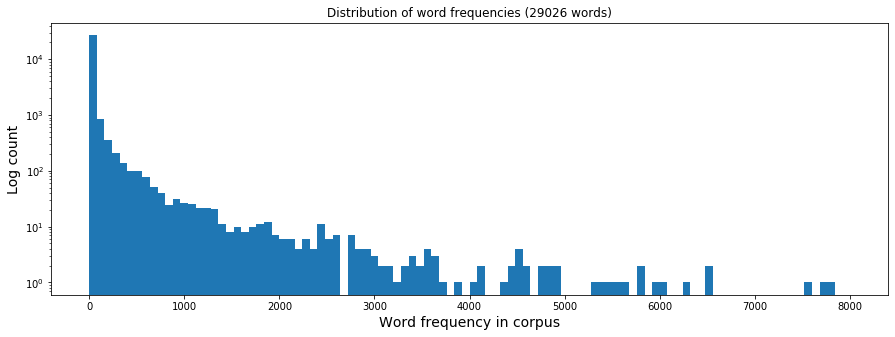

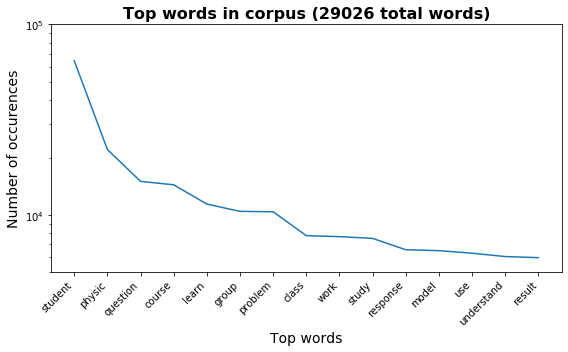

In [3]:
def plot_freq_dist(freq_list, **kwargs):
    '''
    Plot distribution of word frequencies
    '''
    fig = plt.subplots(figsize=(15,5))
    _ = plt.hist(freq_list, bins=100, **kwargs);
    _ = plt.title("Distribution of word frequencies ("+str(len(freq_list))+" words)");
    _ = plt.xlabel("Word frequency in corpus", {'fontsize': 14});
    _ = plt.ylabel("Log count", {'fontsize': 14});
    plt.yscale('log', nonposy='clip');
    plt.show();
    return fig

def get_top_n_words(corpus, n_top_words=None):
    '''
    Plot frequency distribution of top n word 
    corpus: list of tokens
    n_top_words: number of most frequent words to plot
    '''
    count_vectorizer = CountVectorizer(stop_words='english')
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx], idx) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return zip(*words_freq[:n_top_words])

def plot_words_freq(word_list, freq_list, n_top_words=20, ylim=None):
    fig, ax = plt.subplots(figsize=(8,5))
    word_len = str(len(word_list))
    freq_list = freq_list[:n_top_words]
    word_list = word_list[:n_top_words]
    ax.plot(range(len(freq_list)), freq_list);
    ax.set_xticks(range(len(word_list)));
    xticks = list(map(lambda w: str(w), word_list));
    ax.set_xticklabels(xticks, rotation=45, ha='right', fontdict={'fontweight': 'normal'});
    ax.set_title('Top words in corpus (' + word_len + ' total words)', {'fontsize': 16, 'fontweight': 'bold'});
    ax.set_xlabel('Top words', {'fontsize': 14});
    ax.set_ylabel('Number of occurences', {'fontsize': 14});
    ax.set_yscale('log', nonposy='clip', );
    if ylim:
        ax.set_ylim(ylim)
    else:
        ax.set_ylim([10**(np.floor(np.log10(min(freq[:20]))*10)/10), 10**(np.ceil(np.log10(max(freq_list))*10)/10)]);    
    plt.tight_layout()
    plt.show();
    return fig, ax

corpus = [ w for doc in data_words_bigrams for w in doc ]
print('Total words: \033[1m%d\033[0m, unique words: \033[1m%d\033[0m' % (len(corpus), len(set(corpus))))

[words, freq, ids] = get_top_n_words(corpus, n_top_words=None)
fig = plot_freq_dist(freq, range=[0,8000])
fig, ax = plot_words_freq(words, freq, 15, [5000,100000])

As we can see, the top words in the dataset include "student", "physic" (lemmatized version of physics/physical), "question", "course", "learn", and "problem". Because these words are so overrepresented, they need to be filtered out. This is an essential step, since topic models like LDA are based on word co-occurences, which means that word that are over-represented in the data can wash out the more interesting trends in our data (i.e., words that are theoretically relevant to particular subgroups of PER). 

### B. Creating a Bag of Words to filter the dataset

Thankfully, Gensim already has a built-in function to do this kind of filtering, "filter_extremes", which allows us to filter out words that appear too many or too few times. The parameters are:
* **no_below**: an integer. Keep tokens which are contained in at least no_below documents.  
* **no_above**: a float number between 0 and 1. It filters out tokens which are contained in more than no_above percentage of documents. E.g. with no_above=0.5, tokens in in more than 50% of the documents get cut out.  
* **keep_n**: an integer. It specifies how many tokens should be kept, starting with the most frequent.

However, to use this function we must first create a [Gensim Dictionary](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary), which is a mapping between each of the entries (i.e. normalized words) and its integer id in the corpus. 

Based on repeated runs with different filtering values, we've set the no_above parameter to 0.55, which filters out 103 words (displayed below). We have also tried out a variety of no_below values, and have found that no_below 15 gives us more coherent topics. With the filter set to 15, we remove a large amount of the dataset (roughly 24,300 words). However, our primary goal is to find themes and topics that have been prevalent across the PER community over time, and because none of these words occurs in more than 15 documents (out of ~1300), we feel that they are unlikely to add a lot of meaning to the analysis.

After the filtering we convert the remaining tokens into a "bag of words" (BoW).

Unfiltered Dictionary contains 29049 unique words

Applying no_above=0.55 removes 103 words:
 ['able', 'analysis', 'analyze', 'answer', 'approach', 'ask', 'base', 'begin', 'case', 'change', 'class', 'common', 'compare', 'complete', 'concept', 'conceptual', 'consider', 'context', 'course', 'data', 'department', 'design', 'determine', 'develop', 'developed', 'difference', 'different', 'discussion', 'education', 'example', 'experience', 'explain', 'focus', 'follow', 'give', 'goal', 'group', 'help', 'high', 'idea', 'identify', 'important', 'include', 'indicate', 'individual', 'instruction', 'instructor', 'introductory', 'involve', 'keywords', 'know', 'knowledge', 'large', 'learn', 'level', 'like', 'make', 'mean', 'model', 'need', 'new', 'note', 'number', 'order', 'paper', 'particular', 'physic', 'point', 'possible', 'present', 'problem', 'process', 'provide', 'question', 'reason', 'related', 'require', 'research', 'response', 'result', 'science', 'second', 'set', 'show', 'similar', 'small'

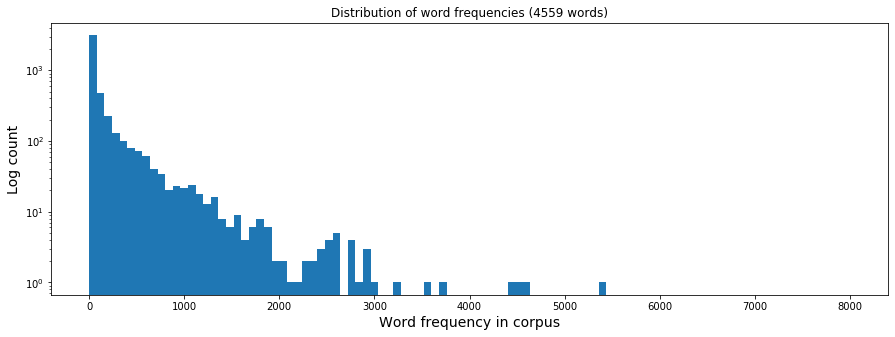

(<Figure size 1080x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1e77ced0>)

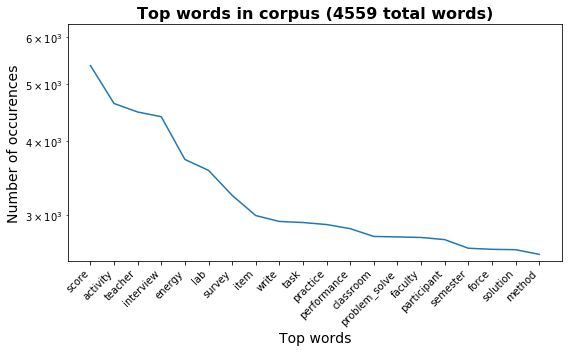

(<Figure size 576x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a23a5ec90>)

In [4]:
no_below = 15
no_above = 0.55

id2word_unfiltered = gensim.corpora.Dictionary(data_words_bigrams) #Needed for a bug
print("Unfiltered Dictionary contains \033[1m%d\033[0m unique words" % len(id2word_unfiltered))

id2word = gensim.corpora.Dictionary(data_words_bigrams)
id2word.filter_extremes(no_below=0, no_above=no_above, keep_n=100000)

#Effect of using no_above
diff_set = set(list(id2word_unfiltered.values())) - set(list(id2word.values()))
print("\nApplying \033[1mno_above=%.2f removes %d words\033[0m:\n %s \n" % (no_above, len(diff_set), sorted(diff_set)))

id2word.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000) #NB: no problem filtering again on no_above
print("Filtered Dictionary contains \033[1m%d\033[0m unique words\n" % len(id2word))

#Create BoW
bow_corpus = [id2word.doc2bow(doc) for doc in data_words_bigrams]

#Get most frequent words from id2word Dictionary
#There is a bug with csf: https://github.com/RaRe-Technologies/gensim/issues/2574
[ids, freq] = zip(*sorted(id2word.cfs.items(), key=lambda x: x[1], reverse=True))
words = [id2word_unfiltered[id] for id in ids]  #have to use id2word_unfiltered to retrieve words from ids!!
# Plot distribution
plot_freq_dist(freq, range=[0,8000])
plot_words_freq(words, freq, 20, ylim=None)


## III. Running LDA using Bag of Words

### A. Explanation of LDA

Now, the good part, the topic modeling. To do the modeling, we are using a technique known as Latent Dirichlet Allocation, or LDA. 1. LDA assumes the following generative process for documents: for each document, pick a particular topic according to a certain distribution. Within each topic, pick words based on a particular distribution. The algorithm tries to determine (estimate, fit) these distributions through a stochastic sampling process, based on the co-occurrence of words in the document. It ends up with two things that it estimates: a distribution of topics within each document, and a distribution of words within each topic. In practice, these end up being matrices: one is a document-topic matrix, which has rows corresponding to documents and columns corresponding to the amount of each topic the model predicts is present in each document (dimensions Num_docs x Num_topics). The other is a topic-term matrix, where each row is a topic and each column is a single word from the corpus (dimensions Num_topics x Num_words). Thus, this technique can also be thought of as a kind of probabilistic matrix factorization (see [Hoffman](https://www.researchgate.net/publication/221618332_Online_Learning_for_Latent_Dirichlet_Allocation) for more on this).

The particular distributions depend on parameters that are fed to the model: $\alpha$ tells the model whether is should expect a small number of topics per document (small $\alpha$), vs a larger number in a more even mixture (large $\alpha$). Similarly, $\beta$ is a parameter that controls whether topics have a few central words, or a larger number of more evenly distributed words. Both are based on the [Dirichlet distribution](https://towardsdatascience.com/dirichlet-distribution-a82ab942a879), which essentially is a function that allows you to specify a distribution across a probability simplex (a kind of generalized shape with several “corners”) where the parameter you feed it specifies how likely points are to fall into a specific corner vs. be distributed evenly across the shape. Note, however, that in both of these matrices, each row is a probability distribution across different discrete outcomes (choice of topics or choice of words) and so each row will add up to 1. And, their values will vary considerably. For example, in the topic-word matrix if you had a corpus of 4000 words and every word was equally likely to be chosen for a particular topic, the values in the that row of the (topics x words) matrix would all be 1/4000 = .00025 = 2.5e-4. However, in practice, for particular topics a large number of words will be rated very low, on the order of 1e-6 or 1e-7, while certain other words will be rated highly, on the order of 1e-2 or even higher. It is therefore common when presenting topics to pick the 5-10 most likely words for a particular topic

### B. Training our LDA model

We call the LdaModel function (which does the actual LDA modeling). We pass the following arguments:  
* bow_corpus - our data corpus, in a "bag of words" format  
* num_topics - the number of topics we intend the algorithm to identify. We set this to 10.  
* id2word - the dictionary that maps words to IDs  
* passes - the number of passes the algorithm should take through the data while training
* iterations - the number of iterations the algorithm will use to try to make the results converge

In addition, we pass three other arguments that are particular to the specific model that we are trying to replicate:
* random_state - a random seed value that determines the initialization of the model, which will affect the specific topics it eventually settles on
* alpha - a parameter that determines how mixed the topics are in each document. In this model, alpha will be 0.1 for each of the 10 topics, meaning topics are fairly distinct and each document only has a few (above 1 means each document is likely to have a mixture, below 1 gives more distinct topics)

The output here is a set of topics, each of which contains a set of words with their corresponding weights.

In [5]:
num_topics = 10
alphatot = 12.5
lda_model = gensim.models.LdaMulticore(corpus=bow_corpus, 
                                   id2word=id2word, 
                                   num_topics=num_topics,
                                   alpha=[alphatot/num_topics] * num_topics,
                                   random_state=430,
                                   iterations=15, passes=50)                 

lda_model.show_topics(num_words=6, formatted=True)

[(0,
  '0.014*"representation" + 0.013*"diagram" + 0.011*"force" + 0.009*"equation" + 0.009*"vector" + 0.008*"charge"'),
 (1,
  '0.021*"problem_solve" + 0.019*"solution" + 0.014*"task" + 0.013*"solve" + 0.011*"write" + 0.008*"strategy"'),
 (2,
  '0.042*"lab" + 0.028*"activity" + 0.022*"experiment" + 0.012*"laboratory" + 0.010*"simulation" + 0.010*"experimental"'),
 (3,
  '0.031*"item" + 0.011*"correct" + 0.011*"score" + 0.010*"assessment" + 0.010*"post_test" + 0.009*"version"'),
 (4,
  '0.052*"teacher" + 0.014*"classroom" + 0.011*"activity" + 0.010*"content" + 0.009*"school" + 0.009*"curriculum"'),
 (5,
  '0.026*"state" + 0.017*"vector" + 0.012*"difficulty" + 0.012*"quantum_mechanic" + 0.011*"quantum" + 0.010*"interview"'),
 (6,
  '0.016*"community" + 0.013*"program" + 0.011*"participant" + 0.010*"identity" + 0.009*"practice" + 0.008*"project"'),
 (7,
  '0.020*"energy" + 0.011*"resource" + 0.011*"interview" + 0.007*"object" + 0.006*"explanation" + 0.006*"say"'),
 (8,
  '0.022*"tutorial

As one can see, the output of the LDA model is a set of "topics" (we specified the exact number with the num_topics parameter) each of which is composed of words with specific weights. For the purposes of illustration, we have sorted these topics by their most weighted words: For example, Topic 0 includes the words "tutorial, ta, lecture, section, force, and semester" (more words are visible if we increase the num_words parameter in the show_topics method). It's helpful here to remember that from a statistical perspective, each of these topics is essentially a distribution over all of the words in the data corpus, which tells us how likely one would be to draw a particular word, given a particular topic, in the generative process for documents that LDA assumes (described above).

One can get the entire distribution using the "get_topics()" method. For example, here is the vector for topic 8, along with the lowest and highest values.

In [6]:
print("Distribution vector for topic 8: ", lda_model.get_topics()[8], "\n")

print("Maximum value: {} corresponding to the word {}".format(np.amax(lda_model.get_topics()[8]), id2word[np.argmax(lda_model.get_topics()[8])]))
print("Minimum value: {} corresponding to the word {}".format(np.amin(lda_model.get_topics()[8]), id2word[np.argmin(lda_model.get_topics()[8])]))

Distribution vector for topic 8:  [2.2691747e-05 5.6166653e-05 1.4537271e-05 ... 1.5471241e-04 1.5464676e-06
 1.4010761e-06] 

Maximum value: 0.022138213738799095 corresponding to the word tutorial
Minimum value: 1.0797862159961369e-06 corresponding to the word hewlett_foundation


As expected, the maximum value was around 0.0221, which corresponds to the word "tutorial". The lowest value is 1.4e-6, corresponding to the bigram "hewlett_foundation". Thus, in the "draw a topic/draw a word" process described above, one would be 20000 times more likely to draw the word tutorial than to draw the bigram "hewlett_foundation".

One can also start to associate specific themes with each set of topics. For example, Topic 0 focuses on representations; Topic 1 is likely to encompass research related to student performance on problem solving tasks and assessments; Topic 2 focuses on labs; and Topic 8 focuses on tutorials, plus TAs and LAs.

### C. Evaluating models with perplexity and coherence scores
We can evaluate the "goodness" of our topic models using two measures, perplexity and coherence score. Perplexity is essentially a statistical measure of the log probability of unseen test documents fitting into the model (based on the geometric mean of the per-word likelihood). It’s useful for selecting a model but not so useful for topic evaluation since it has been shown to be uncorrelated with human interpretability (Newman et al., 2010). For this reason, coherence is more often used. Coherence measures the degree of semantic similarity between high scoring words in the topic—in other words, are these words roughly being used the same, based on the other words they appear with? These measurements help distinguish between topics that are semantically interpretable ("hang together") and topics that are artifacts of the statistical process LDA uses (Röder, Both, and Hinneburg, 2015).

For the purposes of illustration, we compute both the perplexity and the coherence on the topics we've found. Perplexity is a score in the range from -14 to 14, with lower perplexity being better. Coherence ranges from 0-1, with higher scores being better. We have typically found coherence scores between 0.4-0.5, which stackexchange informs us is okay but not great. We suspect this is because our data is relatively homogeneous—that is, all documents are on variations of topics related to physics education, so it's hard to get distinct topics. If, instead, we were analyzing a mixture of documents about 3 distinct subjects (say, sports, religion, and technology companies) we might expect more distinct topics with a higher overall coherence.

In [7]:
#Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_lda = gensim.models.CoherenceModel(model=lda_model, 
                                             texts=data_words_bigrams, 
                                             dictionary=id2word, 
                                             coherence='c_v',
                                             topn=20).get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -7.325426453539157

Coherence Score:  0.4917970146095101


Of these two measures, both we and the literature (e.g., Röder, Both, and Hinneburg, 2015) have found coherence to be more useful for predicting interpretable topics so we have used it in making decisions about our model. As one can see, this particular model is on the high end of our observed coherence score range (0.49). 

## IV. Results of the model: Visualization, representative papers, and prevalence of topics over time

### A. Visualizing the model

With this model trained, we can use it to explore a variety of different aspects of the resulting topics and their relation to the literature. First, we can use the pyLDAvis package to visualize the topics and see how distinct they are from one another in a 2D space created by principle component analysis on the word space. By mousing over the resulting visual, you can see the different topics, their prevalence (indicated by the size of the circles), the most salient terms in each, and their rough inter-topic "distance."

In [8]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, id2word) 
pyLDAvis.display(vis)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


One interesting thing we have noticed with these visuals is that there is often a 2D structure to the space, with one axis (running from the "Energy, resource, interview" cluster to the "Score, performance, survey" cluster) seeming to encompass the divide between qualitative and quantitative studies, and the other axis (going from the "Representation" and "Quantum" clusters to the "K12" and "Community" clusters) seeming to encompass the divide between cognitive and sociocultural work. Clusters focusing on Labs, Problem-Solving, and Tutorials/Research Based Instructional Practices tend to fall in between.

### B. Explaining the PCA variance of pyLDAvis

One interesting question (relevant if we are to take these interpretations seriously) is how much of the variance is encapsulated by the principle component analysis (PCA) used in pyLDAvis. Although there isn't a direct way to make the function output this number, by looking over the [pyLDAvis pcoa documentation](https://pyldavis.readthedocs.io/en/latest/_modules/pyLDAvis/_prepare.html#js_PCoA) and another [script referenced in that documentation](https://github.com/biocore/scikit-bio/blob/0.5.0/skbio/stats/ordination/_principal_coordinate_analysis.py) we've been able to re-create the functions used for the PCA.

In [9]:
from scipy.stats import entropy
from scipy.spatial.distance import pdist, squareform

def jensen_shannon(P, Q):
    M = 0.5 * (P + Q)
    return 0.5 * (entropy(P, M) + entropy(Q, M))

def pcoa(pair_dists, n_components=2):
    """Principal Coordinate Analysis,
    aka Classical Multidimensional Scaling
    """
    # code referenced from skbio.stats.ordination.pcoa
    # https://github.com/biocore/scikit-bio/blob/0.5.0/skbio/stats/ordination/_principal_coordinate_analysis.py

    # pairwise distance matrix is assumed symmetric
    pair_dists = np.asarray(pair_dists, np.float64)

    # perform SVD on double centred distance matrix
    n = pair_dists.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    B = - H.dot(pair_dists ** 2).dot(H) / 2
    eigvals, eigvecs = np.linalg.eig(B)

    # Take first n_components of eigenvalues and eigenvectors
    # sorted in decreasing order
    ix = eigvals.argsort()[::-1]
    eigvals = eigvals[ix]
    eigvecs = eigvecs[:, ix]

    # replace any remaining negative eigenvalues and associated eigenvectors with zeroes
    # at least 1 eigenvalue must be zero
    eigvals[np.isclose(eigvals, 0)] = 0
    if np.any(eigvals < 0):
        ix_neg = eigvals < 0
        eigvals[ix_neg] = np.zeros(eigvals[ix_neg].shape)
        eigvecs[:, ix_neg] = np.zeros(eigvecs[:, ix_neg].shape)
        
    proportion_explained = eigvals / eigvals.sum()

    return np.sqrt(eigvals) * eigvecs, proportion_explained

def js_PCoA(distributions):
    """Dimension reduction via Jensen-Shannon Divergence & Principal Coordinate Analysis
    (aka Classical Multidimensional Scaling)

    Parameters
    ----------
    distributions : array-like, shape (`n_dists`, `k`)
        Matrix of distributions probabilities.

    Returns
    -------
    pcoa : array, shape (`n_dists`, 2)
    """
    dist_matrix = squareform(pdist(distributions, metric=jensen_shannon))
    return pcoa(dist_matrix)

In [10]:
jspcoa, explained = js_PCoA(lda_model.get_topics()) #run PCoA on the normalized topic vectors
print('Variance explained by PC1: {0:.2f} percent'.format(explained[0]*100))
print('Variance explained by PC2: {0:.2f} percent'.format(explained[1]*100))
print('Total variance explained: {0:.2f} percent'.format((explained[0]+explained[1])*100))

Variance explained by PC1: 28.67 percent
Variance explained by PC2: 23.80 percent
Total variance explained: 52.46 percent


### C. Dominant topic in each document

We can also use this model to make an estimation of the document-topic distribution; that is, for a particular document, find out how much the model associates it with each topic.

In [11]:
def get_weight_in_doc(ldamodel, corpus, doc_num, fill=0):
    """ Get the weigth for each topic in a document
    Inputs: ldamodel, corpus, doc_num, fill (value when topic was not found)
    Output: list of tuples [(<topic number>, <topic weight>)]
    """
    num_topics = ldamodel.num_topics
    weights = [fill] * num_topics
    # Get a list of tuples with the detected topics and weights
    row = ldamodel[corpus][doc_num]
    # Process the output to return a list of weights
    tw = list(zip(*row))
    for topic in range(num_topics):
        if topic in tw[0]:
            ind = tw[0].index(topic)
            weights[topic] = tw[1][ind]
    return weights

def get_weight_per_doc(ldamodel, corpus):
    """ Get a document by topic weight Dataframe 
    Inputs: ldamodel, corpus
    """
    num_topics = ldamodel.num_topics
    dataframe = pd.DataFrame(np.zeros((len(corpus),num_topics)), columns=list(range(num_topics)))
    dataframe.index.name = 'Topic weights'
    for i, row in dataframe.iterrows():
        dataframe.iloc[i] = pd.Series(get_weight_in_doc(ldamodel, corpus, i))
    return dataframe

weights = get_weight_per_doc(lda_model, bow_corpus)

Now, we can associate each weight with its respective document, and see how the  model classifies them:

In [12]:
# Load the DataFrame with processed text
df = pd.read_pickle('PERC_metadata.pkl')
# Concatenate the topic weights
df = pd.concat([df, weights], axis = 1)
df.head()

,filename,year,title,authors,0,1,2,3,4,5,6,7,8,9
0,PERC13_Dreyfus.pdf,2013,Negative Energy: Why Interdisciplinary Physics...,"Benjamin W. Dreyfus, Benjamin D. Geller, Julia...",0.264266,0.000000,0.000000,0.000000,0.012230,0.000000,0.028338,0.646791,0.027743,0.000000
1,PERC13_Gaffney.pdf,2013,Using Expectancy Violation To Investigate Stud...,"Jon D. H. Gaffney, Amy L. Housley Gaffney, and...",0.000000,0.026898,0.361524,0.064830,0.000000,0.000000,0.081905,0.010266,0.189859,0.249336
2,PERC13_Seeley.pdf,2013,Assessing for shifts in learner's energy reaso...,Lane Seeley,0.338396,0.000000,0.000000,0.075537,0.167595,0.000000,0.010076,0.384683,0.000000,0.000000
3,PERC13_Sherer.pdf,2013,The Partial Derivative Machine,"Grant Sherer, Mary Bridget Kustusch, Corinne A...",0.598413,0.000000,0.184477,0.020883,0.000000,0.079106,0.021526,0.062462,0.011670,0.000000
4,PERC13_DeVore.pdf,2013,Improving Students' Understanding of Lock-In A...,"Seth DeVore, Alexandre Gauthier, Jeremy Levy, ...",0.000000,0.027450,0.122756,0.327353,0.000000,0.352170,0.000000,0.047971,0.090964,0.013424


This analysis, for example, associates the 2013 paper paper "Negative Energy: Why Interdiscipinary Physics Requires multiple Ontologies" primarily with Topic 7, [0.020*"energy" + 0.011*"resource" + 0.011*"interview" + 0.007*"object" + 0.006*"explanation"], with a weaker association with topic 0 [0.014*"representation" + 0.013*"diagram" + 0.011*"force" + 0.009*"equation"]. This makes sense, since this paper is primarily about energy, but also about students' ontological beliefs about energy, which touches on their representations for the concept.

Using this set of weights, we can make a plot of the topic weight (in a percent) by document number. Although this plot is quite messy, the dots above 0.5 on the y-axis show that there are lots of documents that fall more than 50% into a particular topic.

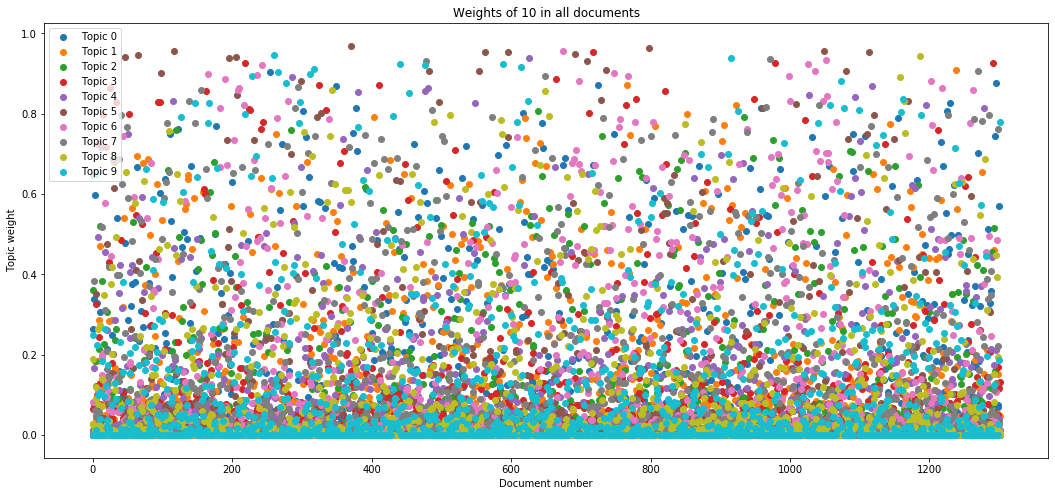

In [13]:
plt.figure(figsize=(18, 8))
for t in range(num_topics):
    plt.scatter(weights.index, weights.iloc[:,t], label='Topic '+str(t))
plt.xlabel("Document number")
plt.ylabel("Topic weight")
plt.legend(loc='upper left')
plt.title('Weights of %d in all documents' % num_topics)
plt.show();

### D. Most representative documents for each topic

We can also go through, topic-by-topic, and find the most representative documents for each topic, which can be useful both for verifying that these topic groupings make sense and to characterize each topic:

In [14]:
pd.set_option('display.max_colwidth', 150)
for t in range(num_topics):
    print("Topic {}: {}".format(t,lda_model.print_topics(num_words=6)[t][1]))
    df.sort_values(by=t, ascending=False)[['year','title','authors',t]][:10]
    print('\n\n')

Topic 0: 0.014*"representation" + 0.013*"diagram" + 0.011*"force" + 0.009*"equation" + 0.009*"vector" + 0.008*"charge"


,year,title,authors,0
254,2017,Student determination of differential area elements in upper-division physics,Benjamin P. Schermerhorn and John R. Thompson,0.903578
1295,2012,Arrows as anchors: Conceptual blending and student use of electric field vector arrows,Elizabeth Gire and Edward Price,0.875317
724,2016,The impact of students' epistemological framing on a task requiring representational consistency,"Alexandru Maries, Shih-Yin Lin, and Chandralekha Singh",0.870700
349,2011,Student Interpretation of the Signs of Definite Integrals Using Graphical Representations,"Rabindra R. Bajracharya, Thomas M. Wemyss, and John R. Thompson",0.869899
1230,2012,Contrasting students’ understanding of electric field and electric force,Alejandro Garza and Genaro Zavala,0.827615
378,2011,Graphical representations of vector functions in upper-division E&M,Elizabeth Gire and Edward Price,0.813699
959,2004,Free-Body Diagrams: Necessary or Sufficient?,"David Rosengrant, A. Van Heuvelen, and Eugenia Etkina",0.813479
1225,2012,Student difficulties in translating between mathematical and graphical representations in introductory physics,"Shih-Yin Lin, Alexandru Maries, and Chandralekha Singh",0.806633
301,2011,Using Analogical Problem Solving with Different Scaffolding Supports to Learn about Friction,Shih-Yin Lin and Chandralekha Singh,0.805997
617,2007,Effect of Misconception on Transfer in Problem Solving,Chandralekha Singh,0.800935





Topic 1: 0.021*"problem_solve" + 0.019*"solution" + 0.014*"task" + 0.013*"solve" + 0.011*"write" + 0.008*"strategy"


,year,title,authors,1
1238,2012,Transfer Of Argumentation Skills In Conceptual Physics Problem Solving,Carina M. Rebello and N. Sanjay Rebello,0.909721
766,2015,How do Multimedia Hints Affect Students’ Eye Movements in Conceptual Physics Problems?,"Xian Wu, John Hutson, Lester C. Loschky, and N. Sanjay Rebello",0.870883
923,2004,Computer Problem-Solving Coaches,Leonardo Hsu and Kenneth Heller,0.821122
853,2015,Effects of Visual Cues and Video Solutions on Conceptual Tasks,"Tianlong Zu, Elise Agra, John Hutson, Lester C. Loschky, and N. Sanjay Rebello",0.800198
403,2003,Expert-Novice Comparisons to Illuminate Differences in Perceptions of Problem Solutions,Kathleen A. Harper,0.790798
620,2007,Students' Perceptions of Case-Reuse Based Problem Solving in Algebra-Based Physics,"Frances Mateycik, Zdeslav Hrepic, David Jonassen, and N. Sanjay Rebello",0.788891
1144,2009,Can We Assess Efficiency and Innovation in Transfer?,N. Sanjay Rebello,0.773769
905,2008,Enhancing Cognitive Development through Physics Problem Solving: A Taxonomy of Introductory Physics Problems,"Raluca E. Teodorescu, Cornelius Bennhold, and Gerald Feldman",0.770916
806,2015,Influence of visual cueing and outcome feedback on students’ visual attention during problem solving,"Elise Agra, Drew Johnson, John Hutson, Lester C. Loschky, and N. Sanjay Rebello",0.769681
263,2017,Use of Eye-Tracking Technology to Investigate Cognitive Load Theory,"Tianlong Zu, John Hutson, Lester C. Loschky, and N. Sanjay Rebello",0.749054





Topic 2: 0.042*"lab" + 0.028*"activity" + 0.022*"experiment" + 0.012*"laboratory" + 0.010*"simulation" + 0.010*"experimental"


,year,title,authors,2
638,2007,Using Students' Design Tasks to Develop Scientific Abilities,Xueli Zou,0.807068
934,2004,Can Computer Simulations Replace Real Equipment in Undergraduate Laboratories?,"Noah D. Finkelstein, Katherine K. Perkins, Wendy K. Adams, Patrick B. Kohl , and Noah S. Podolefsky",0.792824
119,2006,When and How Do Students Engage in Sense-Making in a Physics Lab,Anna Karelina and Eugenia Etkina,0.759454
284,2017,Using lesson design to change student approaches to dorm-room design prelabs,Katherine Ansell and Mats Selen,0.758789
730,2016,Using RealTime Physics with different instructional technologies in a circuits lab,"Mónica Quezada-Espinoza, Angeles Dominguez, and Genaro Zavala",0.744708
975,2018,Dashboard to evaluate student engagement with interactive simulations,"Diana López-Tavares, Katherine K. Perkins, Sam Reid, Michael Kauzmann, and Carlos Aguirre-Vélez",0.733718
1086,2005,Design labs: Students' expectations and reality,Eugenia Etkina and Sahana Murthy,0.707615
1089,2005,Assessing ISLE Labs as an Enhancement to Traditional Large-Lecture Courses at the Ohio State University,Dedra Demaree and Yuhfen Lin,0.704326
850,2015,Designing a lab course from the perspective of flow theory,Anna Karelina,0.702625
985,2018,Confirming what we know: Understanding questionable research practices in intro physics labs,"Martin M. Stein, Emily M. Smith, and Natasha G. Holmes",0.689371





Topic 3: 0.031*"item" + 0.011*"correct" + 0.011*"score" + 0.010*"assessment" + 0.010*"post_test" + 0.009*"version"


,year,title,authors,3
718,2016,Assessing Student Learning and Improving Instruction with Transition Matrices,Paul J. Walter and Gary A. Morris,0.954114
219,2017,Showing the dynamics of student thinking as measured by the FMCE,"Trevor I. Smith, Kerry A. Gray, Kyle J. Louis, Bartholomew J. Ricci, and Nicholas J. Wright",0.926822
979,2018,Determining a hierarchy of correctness through student transitions on the FMCE,"Kyle J. Louis, Bartholomew J. Ricci, and Trevor I. Smith",0.926204
1291,2012,Exploring student difficulties with pressure in a fluid,"Matthew Goszewski, Adam Moyer, Zachary Bazan, and Doris J. Wagner",0.925574
665,2016,A Multi-faceted Approach to Measuring Student Understanding,"Ian T. Griffin, Kyle J. Louis, Ryan Moyer, Nicholas J. Wright, and Trevor I. Smith",0.885777
411,2003,Using the Lunar Phases Concept Inventory to Investigate College students' Pre-instructional Mental Models of Lunar Phases,Rebecca S. Lindell and Steven Sommer,0.870912
324,2011,Item response theory analysis of the mechanics baseline test,"Caroline N. Cardamone, Jonathan E. Abbott, Saif Rayyan, Daniel T. Seaton, Andrew Pawl, and David E. Pritchard",0.870221
25,2013,Exploring Student Difficulties with Buoyancy,"Doris J. Wagner, Elizabeth Carbone, and Ashley Lindow",0.862972
821,2015,Telling new stories by reanalyzing old data: FMCE edition,Trevor I. Smith,0.856816
162,2002,Developing the Lunar Phases Concept Inventory,Rebecca S. Lindell and James P. Olsen,0.856744





Topic 4: 0.052*"teacher" + 0.014*"classroom" + 0.011*"activity" + 0.010*"content" + 0.009*"school" + 0.009*"curriculum"


,year,title,authors,4
626,2007,How Elementary Teachers Use What We Teach: The Impact Of PER At The K-5 Level,Danielle B. Harlow,0.939209
286,2011,Teacher-driven professional development and the pursuit of a sophisticated understanding of inquiry,"Michael J. Ross, Ben Van Dusen, Samson Sherman, and Valerie K. Otero",0.891677
1118,2005,Different Views on Inquiry: A Survey of Science and Mathematics Methods Instructors,Thomas Withee and Rebecca S. Lindell,0.870010
481,2010,Uncovering the Hidden Decisions that Shape Curricula,Danielle B. Harlow,0.865007
477,2010,Learning Pedagogy in Physics,"Danielle B. Harlow, Lauren Swanson, Hilary A. Dwyer, and Julie A. Bianchini",0.856204
381,2003,"""After I gave students their prior knowledge"" Pre-service teachers' conceptions of student prior knowledge",Valerie K. Otero and Mitchell Nathan,0.854349
1027,2018,Physics Teacher-Leaders' Learning in a National Program of Regional Professional Learning Communities,"Smadar Levy, Esther Bagno, Hana Berger, and Bat-Sheva Eylon",0.845426
1094,2005,The Impact of Teacher Quality Grants on Long-Term Professional Development of Physical Science Teachers,Mary Urquhart and Kendra M. Bober,0.842220
115,2006,Beyond Concepts: Transfer from Inquiry-Based Physics to Elementary Classrooms,Danielle B. Harlow and Valerie K. Otero,0.831316
548,2014,Assessing Future Elementary Teachers’ Pedagogical Content Knowledge in a Physics Class,Claudia Fracchiolla and N. Sanjay Rebello,0.826185





Topic 5: 0.026*"state" + 0.017*"vector" + 0.012*"difficulty" + 0.012*"quantum_mechanic" + 0.011*"quantum" + 0.010*"interview"


,year,title,authors,5
370,2011,Students' Difficulties with Quantum Measurement,Guangtian Zhu and Chandralekha Singh,0.969344
798,2015,Student difficulties with quantum states while translating state vectors in Dirac notation to wave functions in position and momentum representations,Emily Marshman and Chandralekha Singh,0.962432
1049,2018,Student difficulties with the corrections to the energy spectrum of the hydrogen atom for the intermediate field Zeeman effect,"Emily Marshman, Christof Keebaugh, and Chandralekha Singh",0.955138
116,2006,Student Difficulties with Quantum Mechanics Formalism,Chandralekha Singh,0.954813
596,2014,Developing an Interactive Tutorial on a Quantum Eraser,Emily Marshman and Chandralekha Singh,0.954691
563,2014,Developing an interactive tutorial on a Mach-Zehnder Interferometer with single photons,Chandralekha Singh and Emily Marshman,0.953739
1114,2005,Assessing and improving student understanding of quantum mechanics,Chandralekha Singh,0.953191
692,2016,Student difficulties with representations of quantum operators corresponding to observables,Emily Marshman and Chandralekha Singh,0.949193
65,2013,Investigating Student Difficulties with Time dependence of Expectation Values in Quantum Mechanics,Emily Marshman and Chandralekha Singh,0.946847
205,2017,Student difficulties with finding the fine structure corrections to the energy spectrum of the hydrogen atom using degenerate perturbation theory,"Chandralekha Singh, Emily Marshman, and Christof Keebaugh",0.941856





Topic 6: 0.016*"community" + 0.013*"program" + 0.011*"participant" + 0.010*"identity" + 0.009*"practice" + 0.008*"project"


,year,title,authors,6
675,2016,Improving representation in physical sciences using a Departmental Action Team,"Katherine Rainey, Joel C. Corbo, Daniel L. Reinholz, and Meredith Betterton",0.955744
1052,2018,Characterizing Models of Informal Physics Programs,"Claudia Fracchiolla, Noah D. Finkelstein, and Kathleen A. Hinko",0.933941
1026,2018,The Intersection of Identity and Performing Arts of Black Physicists,"Tamia Williams, Simone Hyater-Adams, Kathleen A. Hinko, Claudia Fracchiolla, Kerstin Nordstrom, and Noah D. Finkelstein",0.923135
243,2017,An Analysis of Community Formation in Faculty Online Learning Communities,"Alexandra Lau, Melissa H. Dancy, Joel C. Corbo, Charles R. Henderson, and Andy Rundquist",0.921243
1036,2018,Intense Outreach: Experiences Shifting University Students’ Identities,"Brean Prefontaine, Claudia Fracchiolla, Manuel Vasquez, and Kathleen A. Hinko",0.905521
748,2016,Understanding connections between physics and racial identities through recognition and relational resources,"Simone Hyater-Adams, Claudia Fracchiolla, Noah D. Finkelstein, and Kathleen A. Hinko",0.900089
166,2017,Understanding the PICUP community of practice,Paul W. Irving and Marcos D. Caballero,0.898516
235,2017,Applying a Racialized Physics Identity Framework for Black Women From Different Nationalities,"Simone Hyater-Adams, Tamia Williams, Claudia Fracchiolla, Noah D. Finkelstein, and Kathleen A. Hinko",0.896147
999,2018,Facilitators and outcomes of STEM-education groups working toward disciplinary integration,"Juliana L. Fuqua, Jeffery A. Phillips, Anna Bargagliotti, and Dorothea Herreiner",0.894516
768,2015,Departmental Action Teams: Empowering faculty to make sustainable change,"Joel C. Corbo, Daniel L. Reinholz, Melissa H. Dancy, and Noah D. Finkelstein",0.893237





Topic 7: 0.020*"energy" + 0.011*"resource" + 0.011*"interview" + 0.007*"object" + 0.006*"explanation" + 0.006*"say"


,year,title,authors,7
971,2018,Examining the productiveness of student resources in a problem-solving interview,"Lisa M. Goodhew, Amy D. Robertson, Paula R. L. Heron, and Rachel E. Scherr",0.935764
478,2010,Generating Explanations for an Emergent Process: The Movement of Sand Dunes,Lauren Barth-Cohen,0.930525
1269,2012,Examining the Positioning of Ideas in the Disciplines,"Vashti Sawtelle, Tiffany-Rose Sikorski, Chandra Turpen, and Edward F. Redish",0.907360
648,2007,Conceptual Dynamics in Clinical Interviews,"Bruce L. Sherin, Victor R. Lee, and Moshe Krakowski",0.894442
294,2011,Intuitive ontologies for energy in physics,"Rachel E. Scherr, Hunter G. Close, and Sarah B. McKagan",0.866276
156,2002,Student Epistemological Mode Constraining Researcher Access to Student Thinking: An Example from an Interview on Charge Flow,Michael C. Wittmann and Rachel E. Scherr,0.858490
138,2002,The challenge of listening: The effect of researcher agenda on data collection and interpretation,Rachel E. Scherr and Michael C. Wittmann,0.831092
1042,2018,Recurring questions that sustain the sensemaking frame,Tor Ole B. Odden and Rosemary S. Russ,0.822113
965,2004,Concerning Scientific Discourse about Heat,"David T. Brookes, George K. Horton, A. Van Heuvelen, and Eugenia Etkina",0.815431
290,2011,Student views of macroscopic and microscopic energy in physics and biology,"Benjamin W. Dreyfus, Edward F. Redish, and Jessica Watkins",0.813202





Topic 8: 0.022*"tutorial" + 0.021*"faculty" + 0.021*"la" + 0.018*"ta" + 0.018*"lecture" + 0.011*"exam"


,year,title,authors,8
1187,2009,Towards Understanding Classroom Culture: Students’ Perceptions of Tutorials,"Chandra Turpen, Noah D. Finkelstein, and Steven J. Pollock",0.944462
1158,2009,Student Perspectives on Using Clickers in Upper-division Physics Courses,Katherine K. Perkins and Chandra Turpen,0.891162
343,2011,But Does It Last? Sustaining a Research-Based Curriculum in Upper-Division Electricity & Magnetism,"Stephanie V. Chasteen, Rachel E. Pepper, Steven J. Pollock, and Katherine K. Perkins",0.859503
649,2007,Research-based Practices For Effective Clicker Use,"C. J. Keller, Noah D. Finkelstein, Katherine K. Perkins, Steven J. Pollock, Chandra Turpen, and Michael Dubson",0.855799
1163,2009,The Impact of Physics Education Research on the Teaching of Introductory Quantitative Physics,Charles R. Henderson and Melissa H. Dancy,0.832627
512,2001,Class Size Effects in Active Learning Physics Courses,"Charles J. De Leone, Wendell H. Potter, Catherine M. Ishikawa, Jacob Blickenstaff, and Patrick L. Hession",0.797729
654,2007,Understanding How Physics Faculty Use Peer Instruction,Chandra Turpen and Noah D. Finkelstein,0.793914
585,2014,"Studio at CSM: Physics, Biology, and Beyond","Patrick B. Kohl , Eric S. Toberer, Judith N. Schoonmaker, and H. Vincent Kuo",0.785276
490,2010,Faculty Perspectives On Using Peer Instruction: A National Study,"Chandra Turpen, Melissa H. Dancy, and Charles R. Henderson",0.778682
849,2015,Observing Teaching Assistant Differences in Tutorials and Inquiry-Based Labs,"Matthew Wilcox, Caleb C. Kasprzyk, and Jacquelyn J. Chini",0.774328





Topic 9: 0.040*"score" + 0.017*"performance" + 0.014*"survey" + 0.013*"average" + 0.011*"grade" + 0.011*"gain"


,year,title,authors,9
260,2017,Racial and ethnic bias in the Force Concept Inventory,Rachel Henderson and John Stewart,0.946821
915,2008,The Persistence of the Gender Gap in Introductory Physics,"Lauren E. Kost, Steven J. Pollock, and Noah D. Finkelstein",0.939640
588,2014,The Impacts of Instructor and Student Gender on Student Performance in Introductory Modeling Instruction Courses,Daryl McPadden and Eric Brewe,0.924348
441,2010,Improved Student Performance in Electricity and Magnetism Following Prior MAPS Instruction in Mechanics,"Saif Rayyan, Andrew Pawl, Analia Barrantes, Raluca E. Teodorescu, and David E. Pritchard",0.922422
476,2010,Gender Differences in Physics 1: The Impact of a Self-Affirmation Intervention,"Lauren E. Kost-Smith, Steven J. Pollock, Noah D. Finkelstein, Geoffrey L. Cohen, Tiffany A. Ito, and Akira Miyake",0.920330
614,2007,Investigating the Source of the Gender Gap in Introductory Physics,"Lauren E. Kost, Steven J. Pollock, and Noah D. Finkelstein",0.916825
317,2011,"FCI normalized gain, scientific reasoning ability, thinking in physics, and gender effects","Vincent P. Coletta, Jeffery A. Phillips, and Jeffery J. Steinert",0.910258
266,2017,The Role of Students’ Gender and Anxiety in Physics Performance,"Elise Agra, Susan M. Fischer, and Sian L. Beilock",0.903923
312,2011,Replicating a self-affirmation intervention to address gender differences: Successes and challenges,"Lauren E. Kost-Smith, Steven J. Pollock, Noah D. Finkelstein, Geoffrey L. Cohen, Tiffany A. Ito, and Akira Miyake",0.898837
228,2017,The impact of stereotype threat on gender gap in introductory physics,"Alexandru Maries, Nafis I. Karim, and Chandralekha Singh",0.892805


### E. Time plot of topic weights

Finally, we can plot the "prevalence" of each topic as a function of time. That is, for each year we can add up the percentage of each topic in each document from that year's PERC proceedings (normalized by the number of documents) and plot that as a function of time. Intuitively, we can think of this "prevalence" as being a measure of the total number of complete papers published on that topic in that year, found by adding up the fractional topic contributions from each paper each year.

First, we'll do this for each topic separately, to try to see how they have evolved independently of one another. To get a feeling for the variance of each topic, we use a repeated [5-fold cross-validation technique.](https://machinelearningmastery.com/k-fold-cross-validation/) This essentially randomly splits the dataset (in this case, the prevalence counts for each year) into 5 parts, then recalculates the mean while systematically leaving out each of the 5 parts once. We repeat this 20 times, then plot the standard deviation of the result as the error bars. These error bars can therefore be thought of as a kind of measure of how "concentrated" topics are in a few specific papers vs. distributed evenly across the data corpus. Having a topic concentrated in certain papers will result in those papers being left out of the cross-validation more often, leading to a larger spread. A completely even distribution would result in no spread. Therefore, the larger the error bars, the more that topic is concentrated in a few specific papers that year.

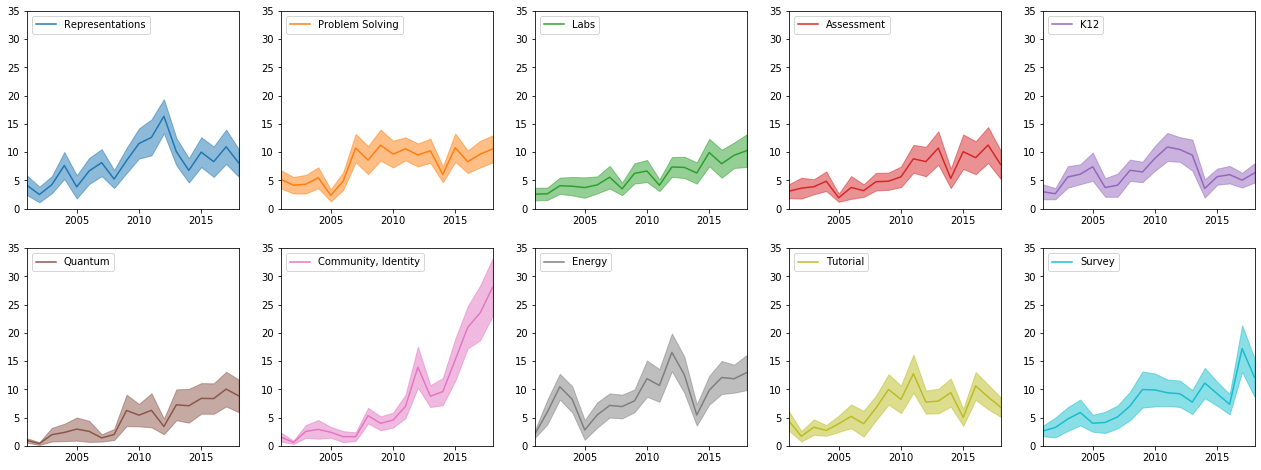

In [15]:
from sklearn.model_selection import RepeatedKFold
n_splits = 5
kf = RepeatedKFold(n_splits=n_splits, n_repeats=20, random_state=1)

func = np.sum
years = range(df.year.min(), df.year.max()+1) 

fig = plt.figure(figsize=(22,8));
#fig.suptitle('\nCumulative Topic Prevalence Over Time');
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

for z in range(10):
    ax = fig.add_subplot(2,5,z+1)
    y = df.groupby('year').agg(func)[z];
    # 5-Fold CV
    err = []
    for year in years:
        df_at_zyear = df.loc[df.year == year][z]
        # Rescale the sum on its length
        estimators = [func(df_at_zyear.iloc[ind_train])*len(df_at_zyear)/len(ind_train) for ind_train, _ in kf.split(df_at_zyear)]
        err.append(np.std(estimators) * 3)
    line, = ax.plot(y, color=cycle[z])
    _ = ax.fill_between(y.index, y-err, y+err, color = line.get_color(), alpha=0.5);
    _ = ax.legend([["Representations", "Problem Solving","Labs","Assessment","K12","Quantum","Community, Identity",\
                    "Energy","Tutorial","Survey"][z]], loc='upper left');
    _ = ax.set_xlim([2001,2018]);
    _ = ax.set_xticks([2005,2010, 2015])
    _ = ax.set_ylim([0,35]);    


Here, we can see that a lot of the topics have remained fairly steady over time. The "Energy" topic has seen an early spike (around 2003) and a later spike (around 2013), along with the Representations topic. Problem-solving saw a pretty big uptick after 2005. And the Community & Identity topic has seen explosive growth in recent years, though the expanding error bars suggests this work is more concentrated in a few specific papers (as is the Quantum topic, unsurprisingly).

It can, however, be tricky to see overall trends with so much year-to-year variation. So, in the next plots we have implemented a smoothing function in the form of a average across a 3-year rolling window. This effectively serves to dampen out small variations, while leaving larger trends intact. However, it also neglects the first and last years.

First, we plot the prevalence, averaged for the number of papers each year. This allows us to see trends that might be watered down by PERC's increasing membership each year.

Topic: 0 
Words: 0.014*"representation" + 0.013*"diagram" + 0.011*"force" + 0.009*"equation" + 0.009*"vector"
Topic: 1 
Words: 0.021*"problem_solve" + 0.019*"solution" + 0.014*"task" + 0.013*"solve" + 0.011*"write"
Topic: 2 
Words: 0.042*"lab" + 0.028*"activity" + 0.022*"experiment" + 0.012*"laboratory" + 0.010*"simulation"
Topic: 3 
Words: 0.031*"item" + 0.011*"correct" + 0.011*"score" + 0.010*"assessment" + 0.010*"post_test"
Topic: 4 
Words: 0.052*"teacher" + 0.014*"classroom" + 0.011*"activity" + 0.010*"content" + 0.009*"school"
Topic: 5 
Words: 0.026*"state" + 0.017*"vector" + 0.012*"difficulty" + 0.012*"quantum_mechanic" + 0.011*"quantum"
Topic: 6 
Words: 0.016*"community" + 0.013*"program" + 0.011*"participant" + 0.010*"identity" + 0.009*"practice"
Topic: 7 
Words: 0.020*"energy" + 0.011*"resource" + 0.011*"interview" + 0.007*"object" + 0.006*"explanation"
Topic: 8 
Words: 0.022*"tutorial" + 0.021*"faculty" + 0.021*"la" + 0.018*"ta" + 0.018*"lecture"
Topic: 9 
Words: 0.040*"score

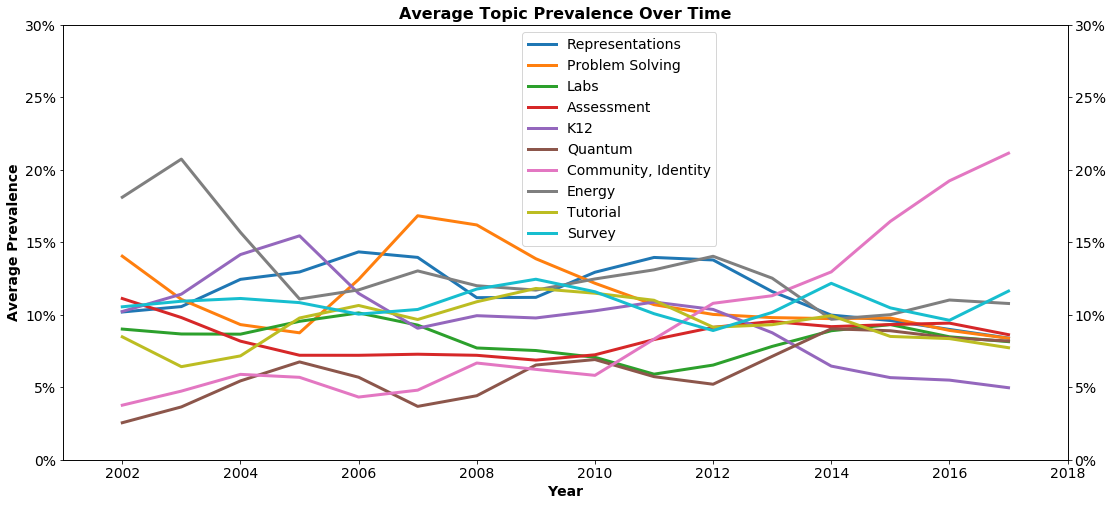

In [16]:
#First, print out the topics, as a reference
for idx, topic in lda_model.print_topics(-1, 5):
    print('Topic: {} \nWords: {}'.format(idx, topic))

#Now, plot the average prevalence
plt.rcParams.update({'font.size': 14}) #set the font size for the figure
d = dict(zip(range(lda_model.num_topics),["Representations", "Problem Solving","Labs","Assessment","K12","Quantum","Community, Identity",\
                    "Energy","Tutorial","Survey"]))
df_prevalnorm = df.groupby('year').agg('mean').rolling(3, min_periods=3, center=True, win_type='triang').mean()
fig, ax1 = plt.subplots(figsize=(18,8))
t = list(df_prevalnorm.index)
for i in df_prevalnorm.columns:
    ax1.plot(t, df_prevalnorm.loc[:,i], linewidth=3, label='%s'%d[i])
ax1.set_xlabel('Year', {'fontsize': 14, 'fontweight': 'bold'})
ax1.set_xlim(2001,2018)
ax1.set_ylim(0,0.3)
from matplotlib.ticker import PercentFormatter
ax1.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax1.set_ylabel('Average Prevalence', {'fontsize': 14, 'fontweight': 'bold'})
ax2 = ax1.twinx()
ax2.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax2.set_ylim(ax1.get_ylim())
ax1.legend(loc='upper left', bbox_to_anchor=(0.45, 0.5, 0.5, 0.5))
plt.title('Average Topic Prevalence Over Time', {'fontsize': 16, 'fontweight': 'bold'});

Although the plot is somewhat crowded, there are three distinct peaks: one in the early years, corresponding to the "energy, resource, object, item, explanation" cluster; one in the middle years, corresponding to the problem-solving cluster; and one in the later years, corresponding to the Community/Identity cluster. These trends, however, are averaged over time, and do not take into account the increased publication rate over time. Such trends become clearer when we sum instead of average:

Topic: 0 
Words: 0.014*"representation" + 0.013*"diagram" + 0.011*"force" + 0.009*"equation" + 0.009*"vector"
Topic: 1 
Words: 0.021*"problem_solve" + 0.019*"solution" + 0.014*"task" + 0.013*"solve" + 0.011*"write"
Topic: 2 
Words: 0.042*"lab" + 0.028*"activity" + 0.022*"experiment" + 0.012*"laboratory" + 0.010*"simulation"
Topic: 3 
Words: 0.031*"item" + 0.011*"correct" + 0.011*"score" + 0.010*"assessment" + 0.010*"post_test"
Topic: 4 
Words: 0.052*"teacher" + 0.014*"classroom" + 0.011*"activity" + 0.010*"content" + 0.009*"school"
Topic: 5 
Words: 0.026*"state" + 0.017*"vector" + 0.012*"difficulty" + 0.012*"quantum_mechanic" + 0.011*"quantum"
Topic: 6 
Words: 0.016*"community" + 0.013*"program" + 0.011*"participant" + 0.010*"identity" + 0.009*"practice"
Topic: 7 
Words: 0.020*"energy" + 0.011*"resource" + 0.011*"interview" + 0.007*"object" + 0.006*"explanation"
Topic: 8 
Words: 0.022*"tutorial" + 0.021*"faculty" + 0.021*"la" + 0.018*"ta" + 0.018*"lecture"
Topic: 9 
Words: 0.040*"score

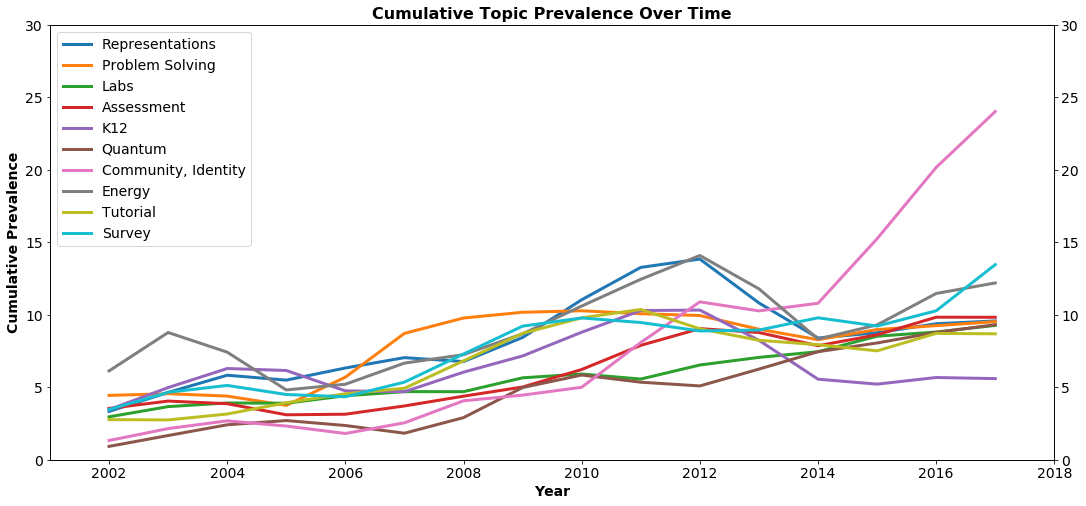

In [17]:
plt.rcParams.update({'font.size': 14})
d = dict(zip(range(lda_model.num_topics),["Representations", "Problem Solving","Labs","Assessment","K12","Quantum","Community, Identity",\
                    "Energy","Tutorial","Survey"]))
for idx, topic in lda_model.print_topics(-1, 5):
    print('Topic: {} \nWords: {}'.format(idx, topic))

from matplotlib.ticker import PercentFormatter
df_prevalsum = df.groupby('year').agg('sum').rolling(3, min_periods=3, center=True, win_type='triang').mean()
fig, ax1 = plt.subplots(figsize=(18,8))
t = list(df_prevalsum.index)
for i in df_prevalsum.columns:
    ax1.plot(t, df_prevalsum.loc[:,i], linewidth=3, label='%s'%d[i])
ax1.set_xlabel('Year', {'fontsize': 14,'fontweight': 'bold'})
ax1.set_xlim(2001,2018)
#ax1.yaxis.set_major_formatter(PercentFormatter(100, decimals=0))
ax1.set_ylim(0,30)
ax1.set_ylabel('Cumulative Prevalence', {'fontsize': 14,'fontweight': 'bold'})
ax2 = ax1.twinx()
#ax2.yaxis.set_major_formatter(PercentFormatter(100, decimals=0))
ax2.set_ylim(ax1.get_ylim())
ax1.legend(loc='upper left')
plt.title('Cumulative Topic Prevalence Over Time', {'fontsize': 16, 'fontweight': 'bold'});

Here we again see the early peak of the qualtative "Energy" cluster. However, this plot highlights the increased prevalence of the "community" + 0.013*"program" + 0.011*"participant" + 0.010*"identity" cluster in recent years.

## V. Conclusions

In conclusion, we have created a script to do topic modeling on PERC proceedings papers. It's worth noting that this type of unsupervised machine learning is very sensitive to initial conditions: if you were to re-run the script with a different random seed, you would almost certainly get a different model, which might group the themes somewhat differently than what we have shown here. This is one major drawback of this technique, since different models will tell different stories about the development of the PER community, and lead to different conclusions about where our field has come from and where it is going. However, the particular model we have chosen to showcase here (random seed 430) was not chosen by accident: it was chosen by running a set of 500 models, each with 10 topics, then doing a cluster analysis of the resulting 5000 topics and finding the single model whose topics were closest to the means of these cluster. Thus, this model can be thought of as a kind of "average" of many different topic model runs.

We see great promise with this technique. In future studies, we intend to explore how this technique might be used to analyze larger datasets from more established fields of education research. For example, the field of Science Education has been publishing papers for over 100 years (the journal Science Education published its first article in 1916). What themes have emerged over that time, and how are they tied to the co-occuring geopolitical events like the launch of Sputnik? We also see great promise in comparing the development of different sub-fields, like physics, chemistry, biology, and math education research, to see whether certain topics have simultaneously emerged around the same times, and/or if certain fields influenced the development of other fields. Finally, we intend to continue to push forward the methodological development of LDA, trying to find ways to stabilize these topic models against different initializations. One possible avenue is to simply use more text data—generally speaking, LDA becomes more stable the more data it is trained on, so a corpus of 20 years' worth of regular-length papers will likely produce more stable topics than a corpus of 4-page papers, which will still be more stable than a corpus of abstracts.

# References

1. Hoffman, M. D., Blei, D. M. & Bach, F. Online Learning for Latent Dirichlet Allocation (Supplementary Material). Nature 0, 1–9 (2010).
2. Newman, D., Lau, J. H., Grieser, K. & Baldwin, T. Automatic evaluation of topic coherence. in NAACL HLT 2010 - Human Language Technologies: The 2010 Annual Conference of the North American Chapter of the Association for Computational Linguistics, Proceedings of the Main Conference 100–108 (2010).
3. Röder, M., Both, A. & Hinneburg, A. Exploring the space of topic coherence measures. WSDM 2015 - Proc. 8th ACM Int. Conf. Web Search Data Min. 399–408 (2015). doi:10.1145/2684822.2685324